Introduction
=========

Hi all, this is my first Kaggle kernel and really one of the first data science problems I've tackled by myself. We'll go through some basic data wrangling then explore a bunch of simple learning methods and see how they stack up against each other. This kernel aims to be primarily educational for any other beginner Kaggler's looking to get started!

Prepping the Data
================

Loading
----------

In [1]:
fr_train = read.csv('../input/train.csv', na.strings='')
fr_test = read.csv('../input/test.csv', na.strings='')

fr_test$Survived = rep(NA, nrow(fr_test))
fr_train$Set = rep("train", nrow(fr_train))
fr_test$Set = rep("test", nrow(fr_test))

fr_titanic = rbind(fr_train, fr_test)

dim(fr_train)
head(fr_train)

[1] 891  13

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Set
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S,train
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C,train
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S,train
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,train
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S,train
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q,train


The head function can be used on a dataframe to view the first n rows, in R the default is n = 6. It's a useful function to get a quick peak at the data you're working with; in particular whether a feature is categorical or numerical, as well as typical values. Right off the bat we can spot an idiosyncracy in our dataset, namely that we seem to be missing a lot of values in our `Cabin` feature. Dealing with missing data is an important step in any machine learning pipeline, and we'll spend a bit of time on it a little later on. But first, let's continue exploring some basic properties of the training portion our dataset.

In [2]:
summary(fr_train)

  PassengerId       Survived          Pclass     
 Min.   :  1.0   Min.   :0.0000   Min.   :1.000  
 1st Qu.:223.5   1st Qu.:0.0000   1st Qu.:2.000  
 Median :446.0   Median :0.0000   Median :3.000  
 Mean   :446.0   Mean   :0.3838   Mean   :2.309  
 3rd Qu.:668.5   3rd Qu.:1.0000   3rd Qu.:3.000  
 Max.   :891.0   Max.   :1.0000   Max.   :3.000  
                                                 
                                    Name         Sex           Age       
 Abbing, Mr. Anthony                  :  1   female:314   Min.   : 0.42  
 Abbott, Mr. Rossmore Edward          :  1   male  :577   1st Qu.:20.12  
 Abbott, Mrs. Stanton (Rosa Hunt)     :  1                Median :28.00  
 Abelson, Mr. Samuel                  :  1                Mean   :29.70  
 Abelson, Mrs. Samuel (Hannah Wizosky):  1                3rd Qu.:38.00  
 Adahl, Mr. Mauritz Nils Martin       :  1                Max.   :80.00  
 (Other)                              :885                NA's   :177    
     Sib

The `summary()` function can be used to summarise basical statistical properties of each feature in a dataframe. Let's run through what we see here.

First of all the mean of `Survived` is 0.38, meaning only 38% of people survived in this dataset. Naturally this means we have more data pertaining to passengers who died, so it wouldn't be too suprising if our model ends up being better at able to predict who dies than who survives but this is something we'll have to evaluate later.

There's also more males than females in this dataset by a fairly significant margin, 577 versus 314. Most interestingly take a look at `Cabin`, there's a whopping 687 NA's. That's a lot of missing data, note that `Age` and `Embarked` are missing values as well but not nearly as much.

I like to quickly make helper functions which give me neat, explicit output about what I'm concerned with. Since we're about to deal with a lot of missing data I'm going to make a short, simple function which summarises the missing data in any generic dataframe.

In [3]:
naSummary = function(df) {
    naCount = sapply(df, function(col) {
        sum(is.na(col))
    })
    
    return (data.frame(naCount, naPc=naCount/nrow(df)))
}

naSummary(fr_titanic)

,naCount,naPc
PassengerId,0,0.0000000000
Survived,418,0.3193277311
Pclass,0,0.0000000000
Name,0,0.0000000000
Sex,0,0.0000000000
Age,263,0.2009167303
SibSp,0,0.0000000000
Parch,0,0.0000000000
Ticket,0,0.0000000000
Fare,1,0.0007639419


Remember we're only missing `Survived` data because we made NA's when merging the test and train sets. Let's take a look at our data types as the last preliminary check to make sure everything looks good.

In [4]:
str(fr_titanic)

'data.frame':	1309 obs. of  13 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 186 levels "A10","A14","A16",..: NA 82 NA 56 NA NA 130 NA NA NA ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Set        : chr  "train" "train" "train" "train" ...


We should remove passenger ID because it's a useless feature, let's also explicitly convert `Survived` to a factor. Remember factors assume no order, categorical features with explicit order should be kept as ints, e.g. `Pclass`.

In [5]:
fr_titanic$Survived = as.factor(fr_titanic$Survived)
#fr_titanic$Pclass = as.factor(fr_titanic$Pclass)

fr_titanic = subset(fr_titanic, select=-c(PassengerId))

str(fr_titanic)

'data.frame':	1309 obs. of  12 variables:
 $ Survived: Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass  : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name    : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket  : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin   : Factor w/ 186 levels "A10","A14","A16",..: NA 82 NA 56 NA NA 130 NA NA NA ...
 $ Embarked: Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Set     : chr  "train" "train" "train" "train" ...


Missing Data Imputation
----------------------

There's essentially two strategies you can employ when you have to deal with missing data. You can throw out the entries with missing variables, or you can replace the missing variables with your best guess. This latter process is called imputation. The downside of throwing data out is simply that you'll have less data to train your model on, but it's really simple to do. Strategies for imputation can range from very easy to quite complex, it's an extensive topic in and of itself and you should spend some time reading up on it.

### Embarked

Let's go from easy to hard, and start off with the `Embarked` feature which is only missing two values. This is a totally trivial amount of missing data so we'll just use a really simple 'most frequent' imputation which is exactly what it sounds like, replace the missing value with the most frequent level for that feature.

In [6]:
mcl = fr_titanic$Embarked[which.max(fr_titanic$Embarked)]
fr_titanic$Embarked[which(is.na(fr_train$Embarked))] = mcl

naSummary(fr_titanic)

,naCount,naPc
Survived,418,0.3193277311
Pclass,0,0.0000000000
Name,0,0.0000000000
Sex,0,0.0000000000
Age,263,0.2009167303
SibSp,0,0.0000000000
Parch,0,0.0000000000
Ticket,0,0.0000000000
Fare,1,0.0007639419
Cabin,1014,0.7746371276


### Fare

We'll do the same thing for our one missing value of Fare, except now that it's a numeric feature we'll use a mean imputation.

In [7]:
fr_titanic$Fare[which(is.na(fr_titanic$Fare))] = mean(fr_titanic$Fare, na.rm=TRUE)
naSummary(fr_titanic)

,naCount,naPc
Survived,418,0.3193277
Pclass,0,0.0000000
Name,0,0.0000000
Sex,0,0.0000000
Age,263,0.2009167
SibSp,0,0.0000000
Parch,0,0.0000000
Ticket,0,0.0000000
Fare,0,0.0000000
Cabin,1014,0.7746371


### Age

`Age` is a bit harder, we're missing a non-trivial amount of values. We're going to attempt a random regression imputation. This involves developing a regression model between `Age` and a set of predictors from the dataset, then adding a residual term to the prediction in order to reintroduce randomosity to the imputed values. Effectively this is another machine learning problem within our bigger Titanic machine learning problem!

We're going to need features so we can do a bit of feature engineering here. In particular I want to extract the Title of each passenger from the `Name` feature, a look at the data shows that the title "Master" seems to be reserved for males under the age of 13. I'd also expect there to be a correlation between the title "Miss" and younger females.

In [8]:
getTitle = function(name) {
    postcom = trimws(strsplit(as.character(name), ',')[[1]][2])
    title = strsplit(postcom, ' ')[[1]][1]
    return (substr(title, 1, nchar(title)-1))
}

fr_titanic$Title = as.factor(sapply(fr_titanic$Name, getTitle))
fr_titanic = fr_titanic[c("Survived", 
                        "Pclass",  
                        "Name",
                        "Title",
                        "Sex", 
                        "Age", 
                        "SibSp", 
                        "Parch", 
                        "Ticket", 
                        "Fare", 
                        "Cabin", 
                        "Embarked",
                        "Set")]

head(fr_titanic)

Survived,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Set
0,3,"Braund, Mr. Owen Harris",Mr,male,22,1,0,A/5 21171,7.2500,NA,S,train
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",Mrs,female,38,1,0,PC 17599,71.2833,C85,C,train
1,3,"Heikkinen, Miss. Laina",Miss,female,26,0,0,STON/O2. 3101282,7.9250,NA,S,train
1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,female,35,1,0,113803,53.1000,C123,S,train
0,3,"Allen, Mr. William Henry",Mr,male,35,0,0,373450,8.0500,NA,S,train
0,3,"Moran, Mr. James",Mr,male,NA,0,0,330877,8.4583,NA,Q,train


So far looks good! Let's use `summary()` to get a better look.

In [9]:
summary(fr_titanic$Title)

Capt      Col      Don     Dona       Dr Jonkheer     Lady    Major 
       1        4        1        1        8        1        1        2 
  Master     Miss     Mlle      Mme       Mr      Mrs       Ms      Rev 
      61      260        2        1      757      197        2        8 
     Sir       th 
       1        1

There's a lot of special titles being used for a small number of passengers. Let's coerce them to common values so we only deal with the following subset of titles:

* Mr
* Mrs
* Miss
* Master

We'll use the following mappings.

* Dr, Rev, Major, Col, Jonkheer, Don, Sir, Capt -> Mr
* Mlle, Ms -> Miss
* Dona, Lady, Mme, th -> Mrs

I think there would be some amount of predictive power to these title if we had more data, but as it stands these honorifics just don't have enough entries to act as standalone features so we're merging them with the most appropriate alternate level.

Since we're removing a lot of levels we have to use the `droplevels()` command to remove them from the feature within R.

In [10]:
mr_alias = c('Dr', 'Rev', 'Major', 'Col', 'Jonkheer', 'Don', 'Sir', 'Capt')
mrs_alias = c('Dona', 'Lady', 'Mme', 'th')
miss_alias = c('Mlle', 'Ms')

fr_titanic$Title[which(fr_titanic$Title %in% mr_alias)] = 'Mr'
fr_titanic$Title[which(fr_titanic$Title %in% mrs_alias)] = 'Mrs'
fr_titanic$Title[which(fr_titanic$Title %in% miss_alias)] = 'Miss'

fr_titanic$Title = droplevels(fr_titanic$Title)
summary(fr_titanic$Title)

Master   Miss     Mr    Mrs 
    61    264    783    201

Great! Now that's all done and we have what's hopefully a useful, additional feature for our Age random regression imputation. We can finally get started with our actual random regression to impute our missing `Age` values.

First I'm going to define a new dataframe which contains only the features we need to deal with to train our regression model, this means excluding `Name`, `Ticket`, `Cabin` as well as all our test data. We also have to exclude `Survived` because we need to impute missing values in the test set as well.

In [11]:
rr_train = subset(fr_titanic, select=-c(Survived, Name, Ticket, Cabin, Set))
rr_train = na.omit(rr_train) # Omits test data as Survived values are all NA's

head(rr_train)

,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Embarked
1,3,Mr,male,22,1,0,7.2500,S
2,1,Mrs,female,38,1,0,71.2833,C
3,3,Miss,female,26,0,0,7.9250,S
4,1,Mrs,female,35,1,0,53.1000,S
5,3,Mr,male,35,0,0,8.0500,S
7,1,Mr,male,54,0,0,51.8625,S


In [12]:
lm.fit = lm(Age ~ ., data=rr_train)
summary(lm.fit)


Call:
lm(formula = Age ~ ., data = rr_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-27.211  -7.836  -1.402   6.464  45.442 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 30.109627  11.272866   2.671  0.00768 ** 
Pclass      -6.228928   0.521007 -11.956  < 2e-16 ***
TitleMiss    3.894527  11.247229   0.346  0.72921    
TitleMr     23.250445   1.795410  12.950  < 2e-16 ***
TitleMrs    17.790986  11.243479   1.582  0.11388    
Sexmale     -7.810124  11.107834  -0.703  0.48214    
SibSp       -1.341378   0.434950  -3.084  0.00210 ** 
Parch       -0.149300   0.473547  -0.315  0.75261    
Fare         0.009604   0.008008   1.199  0.23069    
EmbarkedQ    8.010292   1.826357   4.386 1.27e-05 ***
EmbarkedS    1.619822   0.921048   1.759  0.07893 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.08 on 1035 degrees of freedom
Multiple R-squared:  0.4151,	Adjusted R-squared:  0.4095 
F-statistic: 

Let's take a quick look at these p-values. `Pclass` is a statistically significant feauture in predicting `Age`, boxplots are useful in investigate the nature of the relationship further.

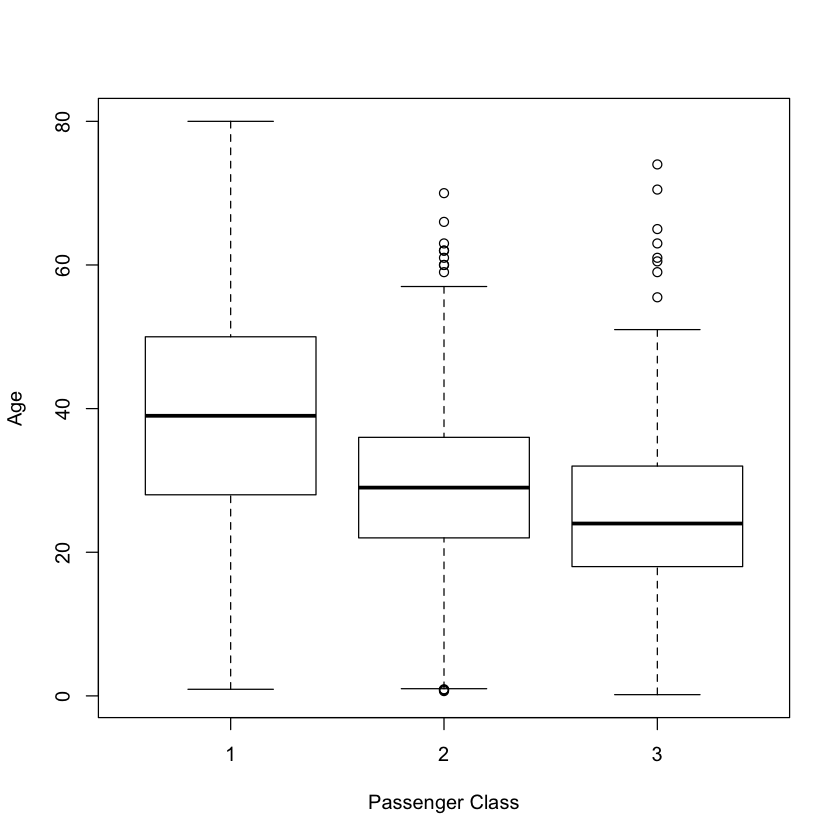

In [39]:
plot(as.factor(rr_train$Pclass), rr_train$Age, xlab="Passenger Class", ylab="Age")

Looks like first class passengers skew older which isn't suprising. `Title` is a significant feature too so our little bit of feature engineering has paid off! `Sex` has no significance in predicting `Age` which isn't particularly surprising. The number of siblings/spouses in `SibSp` is significant as well, my guess is that younger people tend to have a higher count as they likely have siblings on board. Another boxplot should help us determine this.

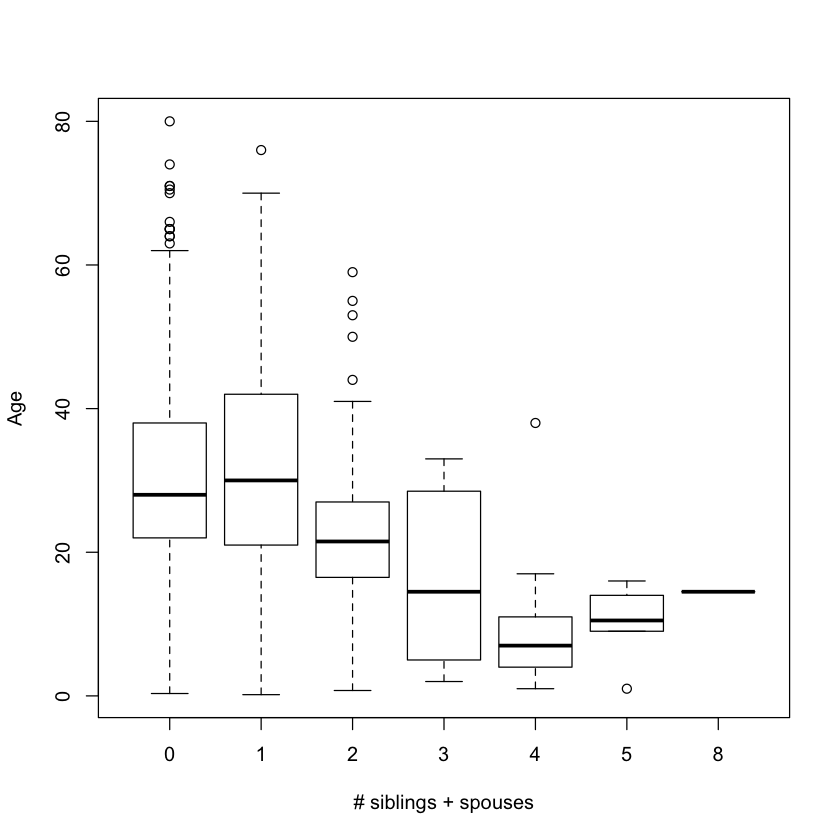

In [14]:
plot(as.factor(rr_train$SibSp), rr_train$Age, xlab="# siblings + spouses", ylab="Age")

Bingo, looks like that's exactly the trend. The last significant feature is `Embarked`, in particular if you embarked from location Q. To be honest I have no idea why, if you do know leave a comment because I'm curious!

Let's create a simpler regression model which excludes the insignificant features: `Sex`, `Parch` and `Fare`.

In [15]:
lm.fit = lm(Age ~ Pclass + Title + SibSp + Embarked, data=rr_train)

summary(lm.fit)


Call:
lm(formula = Age ~ Pclass + Title + SibSp + Embarked, data = rr_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.831  -7.910  -1.282   6.597  45.571 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  23.4214     2.0771  11.276  < 2e-16 ***
Pclass       -6.5796     0.4393 -14.978  < 2e-16 ***
TitleMiss    11.8549     1.8147   6.533 1.01e-10 ***
TitleMr      23.3244     1.7540  13.298  < 2e-16 ***
TitleMrs     25.6259     1.8536  13.825  < 2e-16 ***
SibSp        -1.2878     0.4167  -3.091  0.00205 ** 
EmbarkedQ     7.8567     1.8149   4.329 1.64e-05 ***
EmbarkedS     1.4224     0.9025   1.576  0.11529    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.07 on 1038 degrees of freedom
Multiple R-squared:  0.414,	Adjusted R-squared:  0.4101 
F-statistic: 104.8 on 7 and 1038 DF,  p-value: < 2.2e-16


Now looking at our $R^2$ this definitely isn't the best `Age` predictor but remember this is just for imputation, effectively we're trying to maintain the relationships between `Age` and other variables which exist so as not to diffuse the strength of any patterns in the data when we build our actual Survival predictor. Other strategies like estimating a distribution then sampling from that randomly to fill missing values maintains the state of information we have about `Age`, but potentially weakens the patterns between `Age` and other features.

Finally, let's do our imputation. But first I'm going to see if there's any people with the title "Master" that have missing ages, remember that title appears to be reserved for males under the age of 13. It'll be an interesting test to see if our imputed ages maintain that criteria.

In [16]:
missing_age_masters = which(fr_titanic$Title == 'Master' & is.na(fr_titanic$Age))
fr_titanic[missing_age_masters, ]

,Survived,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Set
66,1,3,"Moubarek, Master. Gerios",Master,male,NA,1,1,2661,15.2458,NA,C,train
160,0,3,"Sage, Master. Thomas Henry",Master,male,NA,8,2,CA. 2343,69.5500,NA,S,train
177,0,3,"Lefebre, Master. Henry Forbes",Master,male,NA,3,1,4133,25.4667,NA,S,train
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",Master,male,NA,1,1,2661,15.2458,NA,C,train
1136,NA,3,"Johnston, Master. William Arthur Willie""""",Master,male,NA,1,2,W./C. 6607,23.4500,NA,S,test
1231,NA,3,"Betros, Master. Seman",Master,male,NA,0,0,2622,7.2292,NA,C,test
1236,NA,3,"van Billiard, Master. James William",Master,male,NA,1,1,A/5. 851,14.5000,NA,S,test
1309,NA,3,"Peter, Master. Michael J",Master,male,NA,1,1,2668,22.3583,NA,C,test


In [17]:
set.seed(10) # this makes the kernel results reproducible

det_imputed = predict(lm.fit, fr_titanic[which(is.na(fr_titanic$Age)), ])
random_imputed = rnorm(length(det_imputed), det_imputed, abs(residuals(lm.fit)))

# We need to round the values to integers and floor them at a value of 1
det_imputed[which(det_imputed < 0)] = 1
det_imputed = round(det_imputed)

random_imputed[which(random_imputed < 0)] = 1
random_imputed = round(random_imputed)

Let's take a look at the original values vs the imputed values.

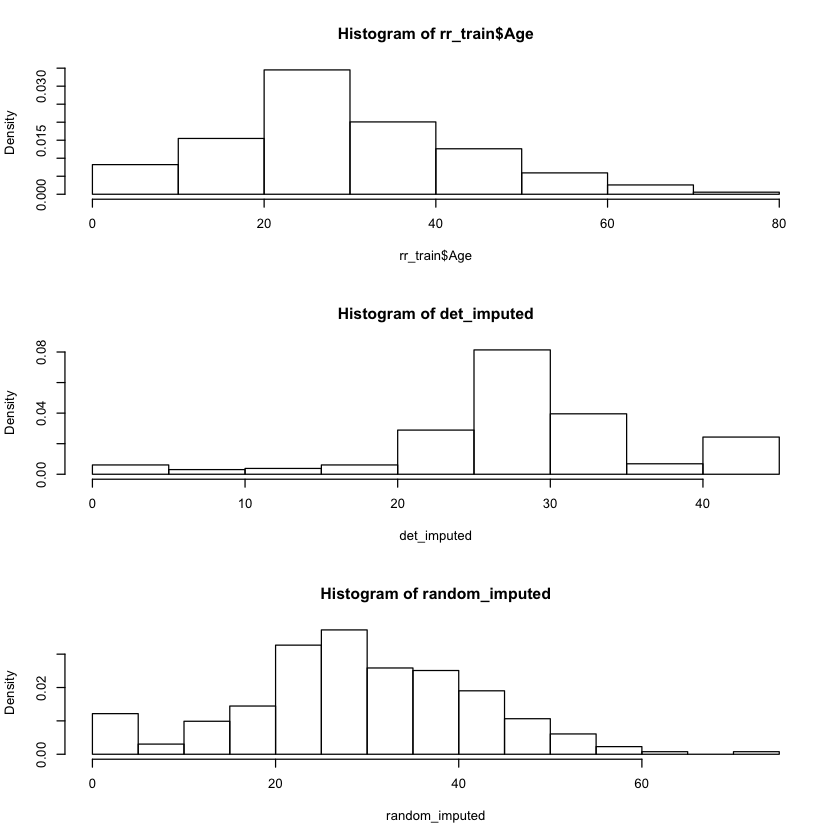

In [18]:
par(mfrow=c(3,1))
hist(rr_train$Age, breaks=10, freq=F)
hist(det_imputed, breaks=10, freq=F)
hist(random_imputed, breaks=10, freq=F)

Under the assumption that the missing values are missing completely at random and with sufficient missing values, we would expect our histograms of the imputed values to be very similar to the original values. This seems to be what we're seeing here. It's also good to compare the deterministic imputations vs the random imputations, the deterministic imputations lie on the regression line by definition. This means that it assumes there's a deterministic relationship between the predictors and the target which is clearly not likely to be accurate. The random imputations take the deterministic imputations and adds an error term proportional to the residuals in the regression fit. Effectively we try and reintroduce appropriate variance in the imputed values.

Violin plots really help us see this effect.

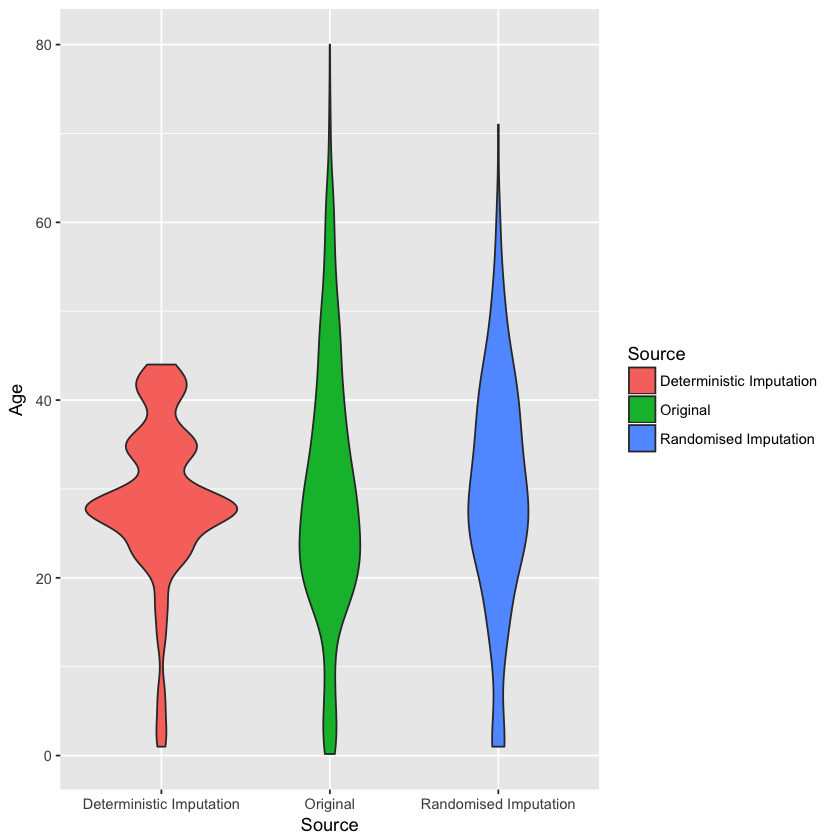

In [19]:
library(ggplot2)

kde_mat = rbind(cbind(rr_train$Age, rep("Original", length(rr_train$Age))),
        cbind(det_imputed, rep("Deterministic Imputation", length(det_imputed))),
        cbind(random_imputed, rep("Randomised Imputation", length(random_imputed))))

kde_df = data.frame(Age=as.numeric(kde_mat[,1]), Source=as.factor(kde_mat[,2]))

ggplot(kde_df, aes(x=Source, y=Age, fill=Source)) + geom_violin()

Let's merge the imputed values back into our dataframe now.

In [20]:
fr_titanic$Age[which(is.na(fr_titanic$Age))] = random_imputed
naSummary(fr_titanic)

,naCount,naPc
Survived,418,0.3193277
Pclass,0,0.0000000
Name,0,0.0000000
Title,0,0.0000000
Sex,0,0.0000000
Age,0,0.0000000
SibSp,0,0.0000000
Parch,0,0.0000000
Ticket,0,0.0000000
Fare,0,0.0000000


Let's go back to the 4 passengers with the "Master" title and missing ages now and see what the randomised imputations they received were.

In [21]:
fr_titanic[missing_age_masters,]

,Survived,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Set
66,1,3,"Moubarek, Master. Gerios",Master,male,1,1,1,2661,15.2458,NA,C,train
160,0,3,"Sage, Master. Thomas Henry",Master,male,1,8,2,CA. 2343,69.5500,NA,S,train
177,0,3,"Lefebre, Master. Henry Forbes",Master,male,1,3,1,4133,25.4667,NA,S,train
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",Master,male,12,1,1,2661,15.2458,NA,C,train
1136,NA,3,"Johnston, Master. William Arthur Willie""""",Master,male,4,1,2,W./C. 6607,23.4500,NA,S,test
1231,NA,3,"Betros, Master. Seman",Master,male,1,0,0,2622,7.2292,NA,C,test
1236,NA,3,"van Billiard, Master. James William",Master,male,4,1,1,A/5. 851,14.5000,NA,S,test
1309,NA,3,"Peter, Master. Michael J",Master,male,1,1,1,2668,22.3583,NA,C,test


Remember we expected them to have an `Age` of less than 13 and we do see that, this is a good indication that our random regression imputation has succeeded in preserving relationships between Age and the other features in the dataset.

### Cabin

Let's be practical, it's not really possible to impute values for `Cabin` given the nature of the data. Instead let's focus on transforming it into a useful feature in the feature engineering phase.

Feature Engineering
===========

Cabin
-----

Since we're missing most of our Cabin values the simplest strategy to see if this could be a useful feature would be to encode it as a simple binary variable, whether a Cabin is listed or not.

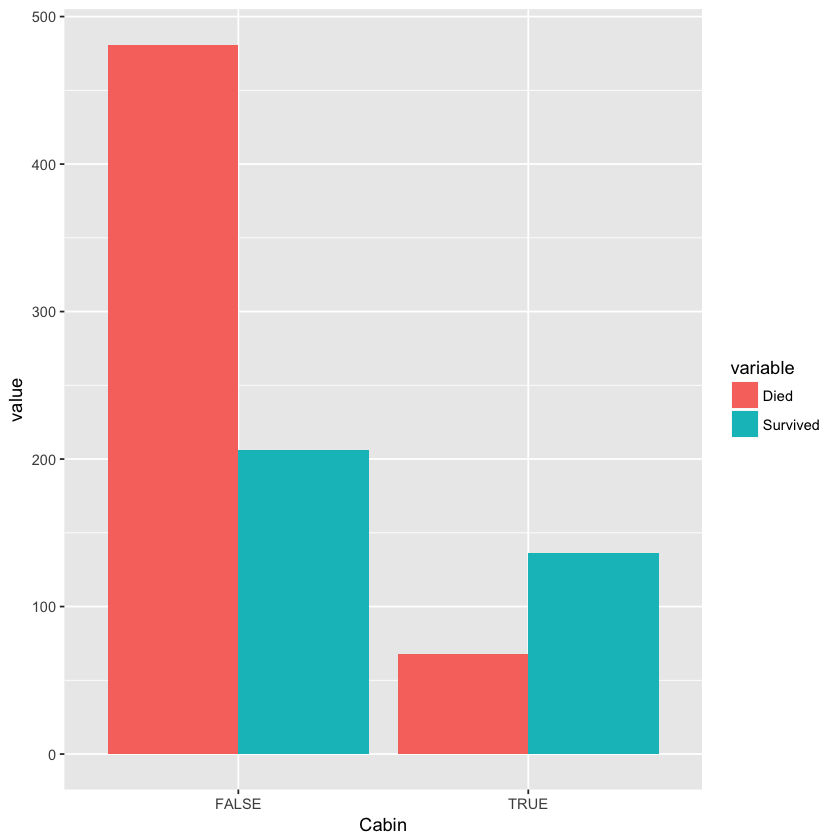

In [22]:
library(reshape2)

fr_titanic$hasCabin = as.factor(!is.na(fr_titanic$Cabin))

# Make a convenience feature which is directly descriptive
Survived_Desc = ifelse(fr_titanic$Survived == 1, "Survived", "Died")

freq = table(fr_titanic$hasCabin, Survived_Desc)
freq_df = as.data.frame.matrix(freq)

freq_df = data.frame(Cabin=row.names(freq_df), freq_df)
freq_df = melt(freq_df, id.vars="Cabin")

ggplot(freq_df, aes(x=Cabin, y=value)) + geom_bar(aes(fill = variable), position = "dodge", stat="identity")

Luckily for us `hasCabin` may actually has some decent predictive power, we can see that those with a listed cabin are far more likely to survive than those without. The next step I think here is to extract the deck out of the `cabin` for each passenger with a `cabin` value and see if there's predictive power associated with that.

In [23]:
fr_titanic$Deck = sapply(fr_titanic$Cabin, function(cabin) {
    substr(as.character(cabin), 1, 1)
})

fr_titanic$Deck[which(is.na(fr_titanic$Deck))] = "None"
fr_titanic$Deck = as.factor(fr_titanic$Deck)

summary(fr_titanic$Deck)

A    B    C    D    E    F    G None    T 
  22   65   94   46   41   21    5 1014    1

Since there's only one value for `T` we'll just coerce it into factor `None`.

In [24]:
fr_titanic$Deck[which(fr_titanic$Deck == 'T')] = as.factor('None')
fr_titanic$Deck = droplevels(fr_titanic$Deck)

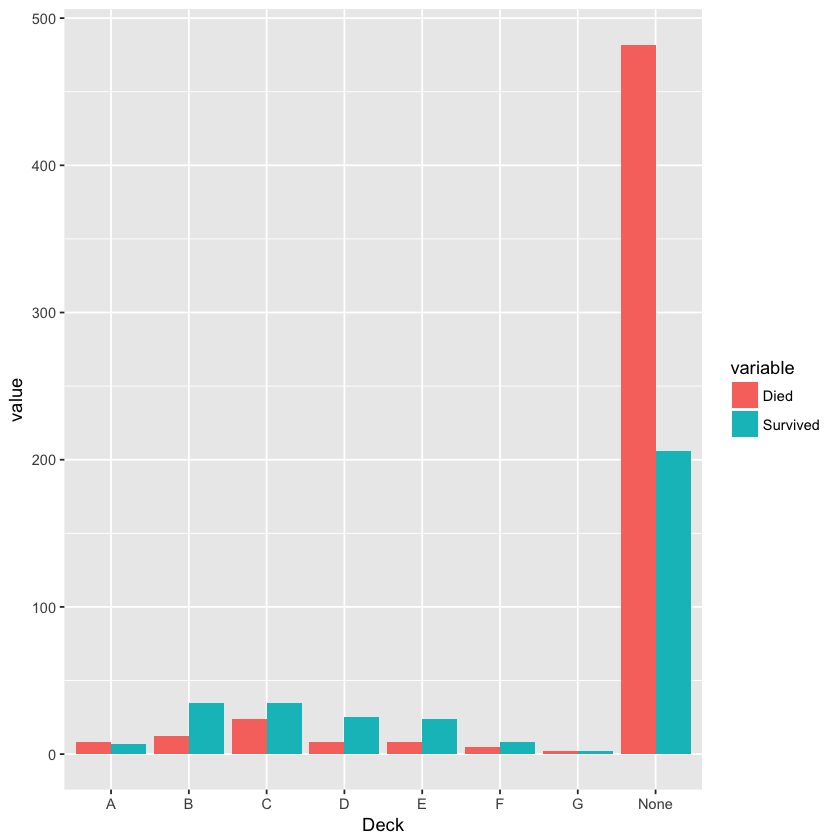

In [25]:
freq = table(fr_titanic$Deck, Survived_Desc)
freq_df = as.data.frame.matrix(freq)
freq_df = data.frame(Deck=row.names(freq_df), freq_df)

freq_df = melt(freq_df, id.vars="Deck")

ggplot(freq_df, aes(x=Deck, y=value)) + geom_bar(aes(fill = variable), position = "dodge", stat="identity")

## Tickets

Since group tickets were available, we can introduce a new feature which guesses whether a person travelled in a group and then see if that has a relationship with survival rate.


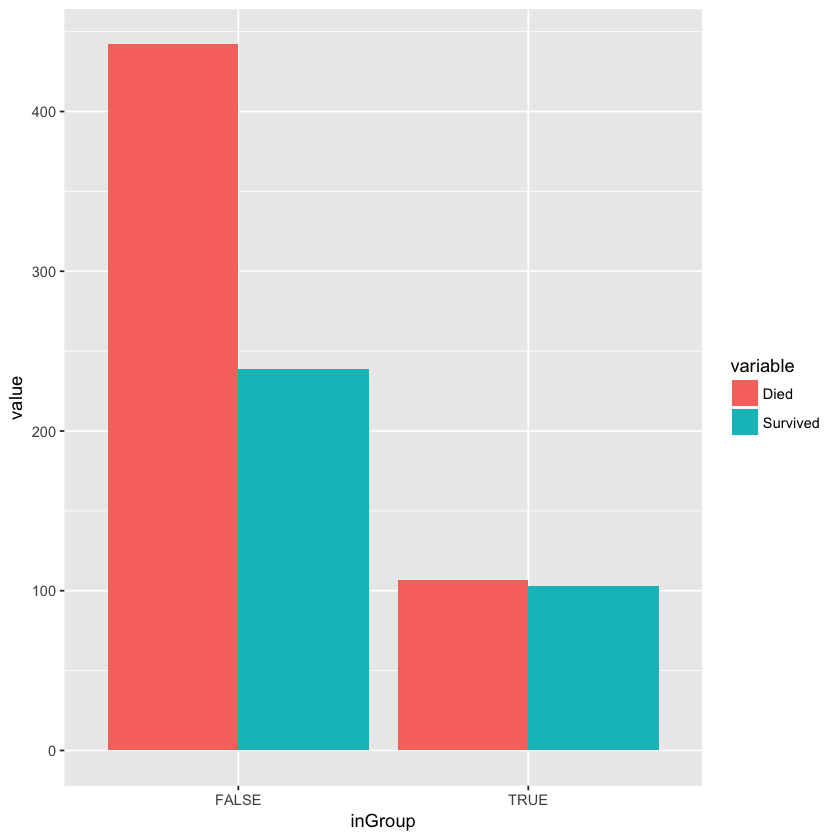

In [26]:
inGroup = as.factor(duplicated(fr_titanic$Ticket))

freq_df = as.data.frame.matrix(table(inGroup, Survived_Desc))
freq_df = data.frame(inGroup=row.names(freq_df), freq_df)

freq_df = melt(freq_df, id.vars="inGroup")

ggplot(freq_df, aes(x=inGroup, y=value)) + geom_bar(aes(fill = variable), position = "dodge", stat="identity")

Looks like if you're not in a group you are more likely to die than those who are not, so we can add this as a proper feature in our dataframe now.

In [27]:
fr_titanic$inGroup = inGroup

## Women and Children First!

We don't really have to worry about the 'woman' part seeing as that's already handled by the `Sex` feature. What we can investigate is whether there's any merit to introducing a new `Child` feature rather than just relying on ages. Or more generally binning the ages into a set of wider levels.

First off let's plot the distribution of `Survival` vs `Age`.

In [28]:
fr_train = fr_titanic[which(fr_titanic$Set == 'train'), ]

uniq_ages = sort(unique(fr_train$Age))

survival_rates_by_age = sapply(uniq_ages, function(age) {
    mean(fr_train[which(fr_train$Age == age), ]$Survived == 1)
})

uniq_ages

[1]  0.42  0.67  0.75  0.83  0.92  1.00  2.00  3.00  4.00  5.00  6.00  7.00
[13]  8.00  9.00 10.00 11.00 12.00 13.00 14.00 14.50 15.00 16.00 17.00 18.00
[25] 19.00 20.00 20.50 21.00 22.00 23.00 23.50 24.00 24.50 25.00 26.00 27.00
[37] 28.00 28.50 29.00 30.00 30.50 31.00 32.00 32.50 33.00 34.00 34.50 35.00
[49] 36.00 36.50 37.00 38.00 39.00 40.00 40.50 41.00 42.00 43.00 44.00 45.00
[61] 45.50 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 55.50
[73] 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 70.00
[85] 70.50 71.00 74.00 80.00

Looks like in the original data there was some fractional ages. Let's round these for simplicity, redo our survival rate calculation, and plot the results.

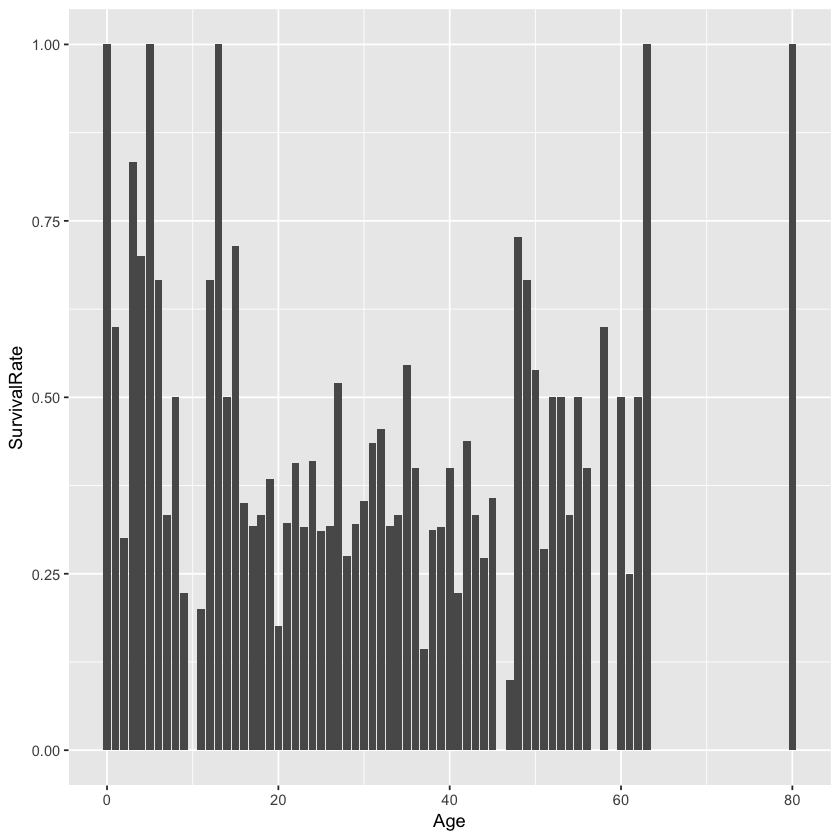

In [29]:
fr_train$Age = round(fr_train$Age)
uniq_ages = sort(unique(fr_train$Age))

survival_rates_by_age = sapply(uniq_ages, function(age) {
    selection = fr_train[which(fr_train$Age == age), ]$Survived
    mean(selection == 1)
})

age_surv_rate_df = data.frame(Age=uniq_ages, SurvivalRate=survival_rates_by_age)
ggplot(age_surv_rate_df, aes(x=Age, y=SurvivalRate)) + geom_col()

There's actually a lot of noise in this plot and it's difficult to make out a clear trend because there's not many samples for each individual age. Instead let's bin the ages into groups of 5 and plot the average survival rate for each bin.

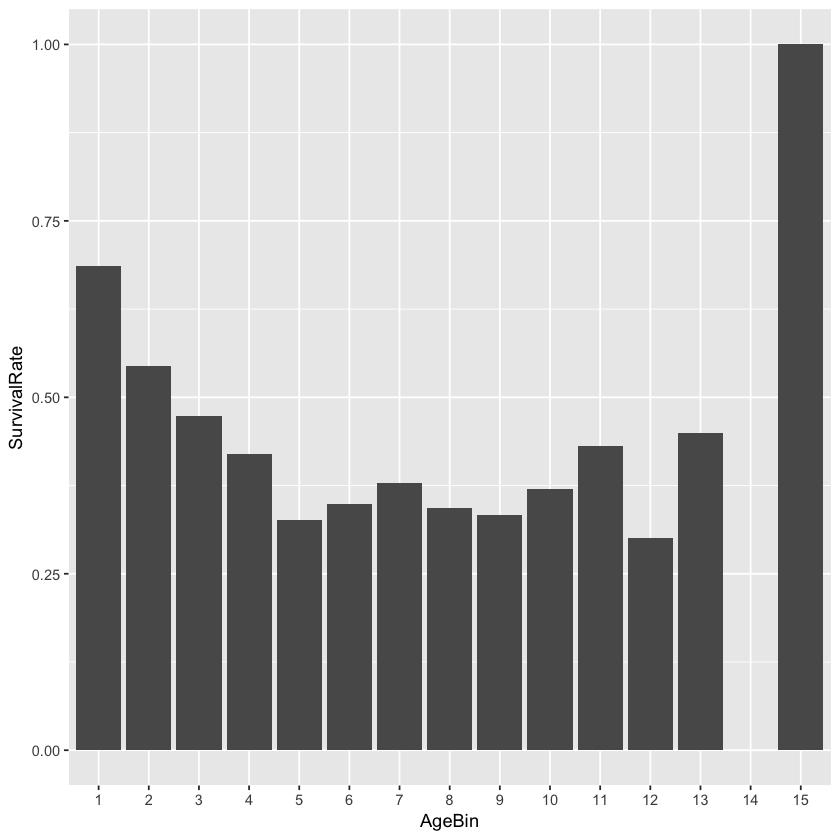

In [40]:
age_bins = split(uniq_ages, ceiling(seq_along(uniq_ages)/5))
binned_surv_rate = sapply(age_bins, function(bin) {
    mean(age_surv_rate_df[which(age_surv_rate_df$Age %in% bin), ]$SurvivalRate)
})

binned_age_surv_df = data.frame(AgeBin=factor(names(age_bins), levels=names(age_bins)), SurvivalRate=binned_surv_rate)
ggplot(binned_age_surv_df, aes(x=AgeBin, y=SurvivalRate)) + geom_col()

This gives us a much clearer picture of what's going on. First off we see that the first bin has the highest survival rate by far, this would correspond to passengers in the age range of 0 to 4. Children typically have a higher survival rate as we can see in bins 2, 3, and 4 which corresponds to ages 5-19. The last bin only contains one measurement of survival and should be effectively considered noise. After that there's no major differences in survival rate outside of an outlier in bin 11, but there's no logical explanation for this I can think of. Based on this info let's engineer a new three level categorical feature based on Age, the levels will be `Toddler` for ages 0-4, `Child` for ages 5-18, and Adult for ages 18+.

In [32]:
fr_titanic$AgeGroup = sapply(fr_titanic$Age, function(age) {
    if (age < 5) {
        return (1)
    } else if (age >= 5 && age < 18) {
        return (2)
    } else {
        return (3)
    }
})

summary(fr_titanic$AgeGroup)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   3.000   2.796   3.000   3.000 

I think this should do in terms of feature engineering for now.

Predictions
======

We'll build both a `Support Vector Classifier` and a `Random Forest` model in this section, compare them, and choose the one that works best.

Split Train and Test Set
-----------------------

First we split our dataframe back into the original train and test sets. Also clean up the data and remove the now unnecessary `Name`, `Ticket`, `Cabin` and `Set` variables as well as the `Survived` variable for the test set.

In [33]:
fr_train = fr_titanic[which(fr_titanic$Set == 'train'),]
fr_test = fr_titanic[which(fr_titanic$Set == 'test'),]

fr_train = subset(fr_train, select=-c(Name, Ticket, Set, Cabin))
fr_test = subset(fr_test, select=-c(Name, Ticket, Set, Cabin, Survived))

head(fr_train)
str(fr_train)
str(fr_test)

Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Embarked,hasCabin,Deck,inGroup,AgeGroup
0,3,Mr,male,22,1,0,7.2500,S,FALSE,None,FALSE,3
1,1,Mrs,female,38,1,0,71.2833,C,TRUE,C,FALSE,3
1,3,Miss,female,26,0,0,7.9250,S,FALSE,None,FALSE,3
1,1,Mrs,female,35,1,0,53.1000,S,TRUE,C,FALSE,3
0,3,Mr,male,35,0,0,8.0500,S,FALSE,None,FALSE,3
0,3,Mr,male,35,0,0,8.4583,Q,FALSE,None,FALSE,3


'data.frame':	891 obs. of  13 variables:
 $ Survived: Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass  : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Title   : Factor w/ 4 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  22 38 26 35 35 35 54 2 27 14 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ hasCabin: Factor w/ 2 levels "FALSE","TRUE": 1 2 1 2 1 1 2 1 1 1 ...
 $ Deck    : Factor w/ 8 levels "A","B","C","D",..: 8 3 8 3 8 8 5 8 8 8 ...
 $ inGroup : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 1 1 1 1 ...
 $ AgeGroup: num  3 3 3 3 3 3 3 1 3 2 ...
'data.frame':	418 obs. of  12 variables:
 $ Pclass  : int  3 3 2 3 3 3 3 2 3 3 ...
 $ Title   : Factor w/ 4 levels "Master","Miss",..: 3 4 3 3 4 3 2 3 4 3 ...
 $ Sex     : Factor w/ 2 level

Support Vector Classifier
-------------------------

In [34]:
library(e1071)

set.seed(7)

tuned = tune(svm, Survived ~ ., data=fr_train, kernel="linear", scale=FALSE, 
             ranges=list(cost=seq(0.3, 0.6, length=20)))

summary(tuned)
svm.fit = tuned$best.model


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
      cost
 0.4263158

- best performance: 0.1717104 

- Detailed performance results:
        cost     error dispersion
1  0.3000000 0.1728340 0.03931962
2  0.3157895 0.1728340 0.03931962
3  0.3315789 0.1728340 0.03931962
4  0.3473684 0.1728340 0.03931962
5  0.3631579 0.1728340 0.03931962
6  0.3789474 0.1739576 0.03825924
7  0.3947368 0.1728340 0.03931962
8  0.4105263 0.1728340 0.03931962
9  0.4263158 0.1717104 0.03961541
10 0.4421053 0.1728340 0.03931962
11 0.4578947 0.1728340 0.03859952
12 0.4736842 0.1750811 0.03713086
13 0.4894737 0.1761923 0.03738589
14 0.5052632 0.1761923 0.03738589
15 0.5210526 0.1750687 0.03743506
16 0.5368421 0.1739451 0.03891626
17 0.5526316 0.1739451 0.03891626
18 0.5684211 0.1750687 0.04101136
19 0.5842105 0.1750687 0.04101136
20 0.6000000 0.1750687 0.04101136


Random Forest
------------

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



      OOB               0                1         
 Min.   :0.1706   Min.   :0.0929   Min.   :0.2836  
 1st Qu.:0.1751   1st Qu.:0.1020   1st Qu.:0.2865  
 Median :0.1751   Median :0.1038   Median :0.2895  
 Mean   :0.1773   Mean   :0.1046   Mean   :0.2942  
 3rd Qu.:0.1776   3rd Qu.:0.1056   3rd Qu.:0.2982  
 Max.   :0.2418   Max.   :0.1411   Max.   :0.3986  

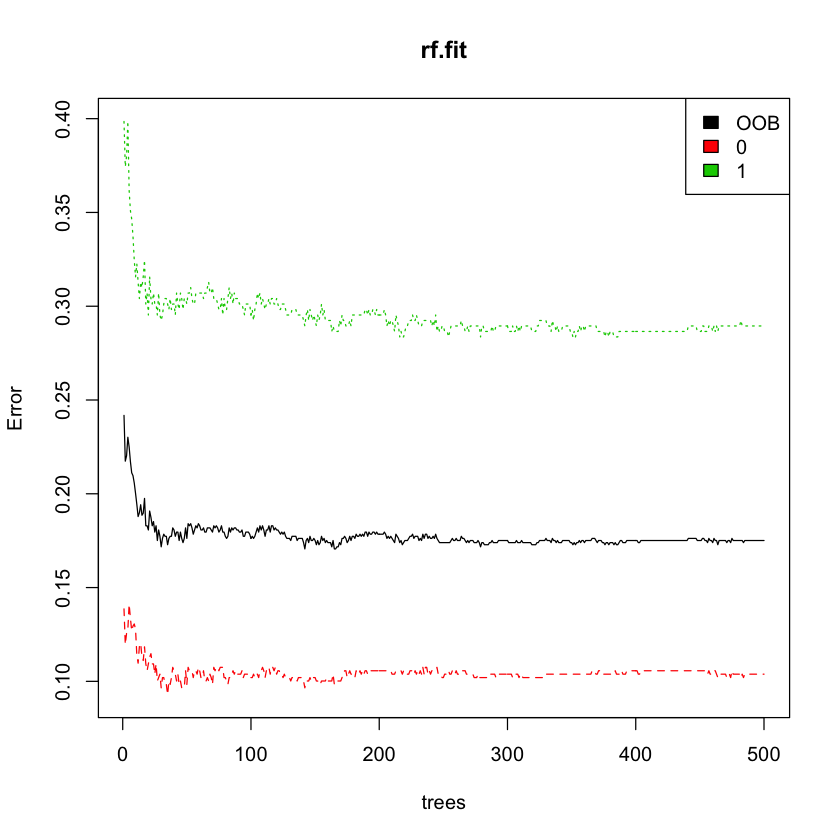

In [35]:
library(randomForest)

set.seed(7)
rf.fit = randomForest(Survived ~ ., data=fr_train)
summary(rf.fit$err.rate)

# Thanks to Megan Risdal's excellent Titanic kernel for this little error rate graph
plot(rf.fit)
legend('topright', colnames(rf.fit$err.rate), col=1:3, fill=1:3)

The first thing to notice here is how much better we are at predicting death than survival. Remember the start of our dataset where we guessed we'd be better at predicting who died than who survived, this seems to have taken effect but in reality this is also simply a consequence of how the Random Forest model works. It'll always perform much better on the bigger class.

The random forest model also slightly outperforms our support vector classifier, which had an error rate of 17.6% as estimated by the 10-fold cross validation. A convenient feature present in the randomForest object is the ability to plot importance measures. Handy as we can see if our feature engineering actually helped us.

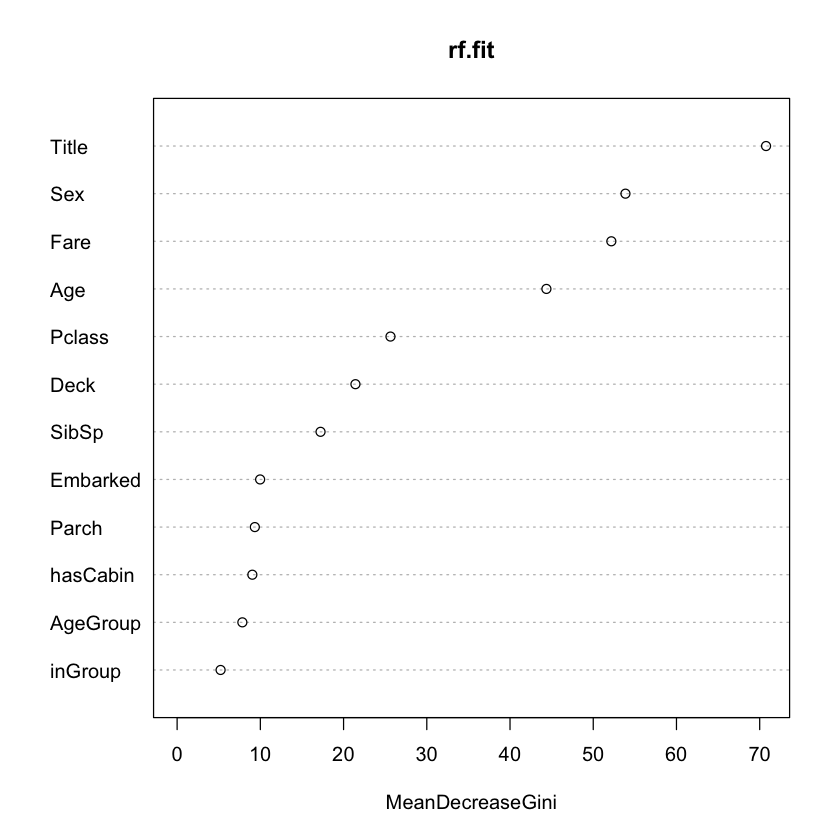

In [36]:
varImpPlot(rf.fit)

Unfortunately it looks like our inGroup and AgeGroup weren't very successful features, Title on the other hand did extremely well!

Making our Prediction File
------------------------

In [37]:
rf.preds = predict(rf.fit, fr_test)
rf.submission = data.frame(PassengerId=names(rf.preds), Survived=rf.preds)
write.csv(rf.submission, file="../output/rf_submission.csv", row.names=FALSE)

svm.preds = predict(svm.fit, fr_test)
svm.submission = data.frame(PassengerId=names(svm.preds), Survived=svm.preds)
write.csv(svm.submission, file="../output/svm_submission.csv", row.names=FALSE)

In [38]:
summary(rf.submission)
summary(svm.submission)


144/(274+174)

  PassengerId  Survived
 1000   :  1   0:276   
 1001   :  1   1:142   
 1002   :  1           
 1003   :  1           
 1004   :  1           
 1005   :  1           
 (Other):412           

  PassengerId  Survived
 1000   :  1   0:254   
 1001   :  1   1:164   
 1002   :  1           
 1003   :  1           
 1004   :  1           
 1005   :  1           
 (Other):412           

[1] 0.3214286

In [77]:
rf.probs = predict(rf.fit, fr_test, type="prob")
rf.skewpreds = ifelse(rf.probs > 0.4, 1, 0)

rf.skewpreds = as.factor(rf.skewpreds[, 2])
all.equal(rf.preds, rf.skewpreds)

summary(rf.skewpreds)

rfskew.submission = data.frame(PassengerId=names(rf.preds), Survived=rf.skewpreds)
write.csv(rfskew.submission, file="../output/rfskew_submission.csv", row.names=FALSE)

[1] "26 string mismatches"

0   1 
250 168

In [ ]:
rf.skewpreds = rep(0, nrow(fr_test))
rf.skewpreds
rf.skewpreds[rf.probs < 0.6] = 1

preds = data.frame(balanced=rf.preds, skewed=rf.skewpreds)

preds

In [47]:
rf.submission[which(rf.submission$Survived != svm.submission$Survived),]

,PassengerId,Survived
893,893,0
896,896,0
910,910,0
925,925,0
926,926,1
928,928,0
929,929,0
933,933,1
941,941,0
964,964,0


In [52]:
fr_titanic[which(rf.submission$Survived != svm.submission$Survived) + 891, ]

,Survived,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Set,hasCabin,Deck,inGroup,AgeGroup
893,NA,3,"Wilkes, Mrs. James (Ellen Needs)",Mrs,female,47.0,1,0,363272,7.0000,NA,S,test,FALSE,None,FALSE,3
896,NA,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",Mrs,female,22.0,1,1,3101298,12.2875,NA,S,test,FALSE,None,TRUE,3
910,NA,3,"Ilmakangas, Miss. Ida Livija",Miss,female,27.0,1,0,STON/O2. 3101270,7.9250,NA,S,test,FALSE,None,FALSE,3
925,NA,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",Mrs,female,30.0,1,2,W./C. 6607,23.4500,NA,S,test,FALSE,None,TRUE,3
926,NA,1,"Mock, Mr. Philipp Edmund",Mr,male,30.0,1,0,13236,57.7500,C78,C,test,TRUE,C,FALSE,3
928,NA,3,"Roth, Miss. Sarah A",Miss,female,21.0,0,0,342712,8.0500,NA,S,test,FALSE,None,FALSE,3
929,NA,3,"Cacic, Miss. Manda",Miss,female,21.0,0,0,315087,8.6625,NA,S,test,FALSE,None,FALSE,3
933,NA,1,"Franklin, Mr. Thomas Parham",Mr,male,40.0,0,0,113778,26.5500,D34,S,test,TRUE,D,FALSE,3
941,NA,3,"Coutts, Mrs. William (Winnie Minnie"" Treanor)""",Mrs,female,36.0,0,2,C.A. 37671,15.9000,NA,S,test,FALSE,None,TRUE,3
964,NA,3,"Nieminen, Miss. Manta Josefina",Miss,female,29.0,0,0,3101297,7.9250,NA,S,test,FALSE,None,FALSE,3
